# AlexNet

## 1 构建AlexNet网络结构
这里使用Keras构建AlexNet

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model, models
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers
%matplotlib inline

In [2]:
##列出你所有的物理GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# 切换为cpu模式
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
tf.keras.backend.clear_session()

class AlexNet(Model):
    def __init__(self):
        '''
            模型要求输入的数据格式channel last, 考虑本地电脑性能问题, 在这里微调AlexNet使其可以输入32*32的图片, 由于微调结构只有一个输出Dense,
            所以用正则化惩罚项代替原文的dropout以缓解过拟合问题。
        '''
        super(AlexNet, self).__init__()
        ####################### stack 1 start ###################################################################
        self.conv_1 = layers.Conv2D(96, kernel_size = (11, 11), strides = (4, 4), padding = "same")
        self.a_1 = layers.Activation('relu')
        self.pool_1 = layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")
        self.bn_1 = layers.BatchNormalization()  # vgg那篇论文指出LRN层没有太大用, 所以这里改成BatchNormalization
        ####################### stack 1 end ###################################################################
        
        ####################### stack 2 start ###################################################################
        self.conv_2 = layers.Conv2D(256, kernel_size = (5, 5), padding = 'same', kernel_regularizer=regularizers.l2(0.001))
        self.a_2 = layers.Activation('relu')
        self.pool_2 = layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")
        self.bn_2 = layers.BatchNormalization()
        ####################### stack 2 end ###################################################################
        
        ####################### stack 3 start ###################################################################
        self.conv_3 = layers.Conv2D(384, kernel_size = (3, 3), padding = 'same')
        self.a_3 = layers.Activation('relu')
        self.conv_4 = layers.Conv2D(384, kernel_size = (3, 3), padding = 'same')
        self.a_4 = layers.Activation('relu')
        self.conv_5 = layers.Conv2D(384, kernel_size = (3, 3), padding = 'same', kernel_regularizer=regularizers.l2(0.001))
        self.a_5 = layers.Activation('relu')
        self.pool_5 = layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")
        ####################### stack 3 end ###################################################################
        
        ####################### stack 4 start ###################################################################
        self.flatten_1 = layers.Flatten()
#         self.fc_6 = layers.Dense(4096, activation = "relu")
        self.pred = layers.Dense(10, activation = "softmax")  # R-CNN论文中fc7去掉了之后, 再不fine-tuning的情况下, 效果还好一点, 所以这里也去掉fc7
        ####################### stack 4 end ###################################################################
    
    def call(self, inputs):
        '''
          TODO: 研究一下Python的语法, 这里应该是可以通过反射重构的
        '''
        x = self.conv_1(inputs)
        x = self.a_1(x)
        x = self.pool_1(x)
        x = self.bn_1(x)

        x = self.conv_2(x)
        x = self.a_2(x)
        x = self.pool_2(x)
        x = self.bn_2(x)
        
        x = self.conv_3(x)
        x = self.a_3(x)
        x = self.conv_4(x)
        x = self.a_4(x)
        x = self.conv_5(x)
        x = self.a_5(x)
        x = self.pool_5(x)
        
        x = self.flatten_1(x)
      # x = self.fc_6(x)
        x = self.pred(x)
        return x

## 2 构建数据集
使用cifar100

### 2.1 使用Python内置函数pickle
cifar10官方建议使用pickle模块的unpickle来实现反序列话, 但是由于TensorFlow的Dataset的流式编程, 传入的都是Tensor对象， 并且是懒执行的, 所以不能直接将pickle与Data整合。

这里的解决方式就是先使用unpickle把所有的数据全部载入内存之中, 再利用Dataset的from_tensor_slices构建数据集。不过这种方法会将所有的数据一次性载入内存, 不适合大数据集。

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return {"data": res[b'data'], "label": res[b'labels']}

In [7]:
dicts = unpickle('./data/cifar-10-batches-py/data_batch_1')

In [8]:
for key in dicts:
    print(key)

data
label


In [9]:
dicts["data"].dtype

dtype('uint8')

In [10]:
dicts["label"][0]

6

In [11]:
# 构建数据集
def create_dataset(file_path, batch_size = 4):
    res = unpickle(file_path)
    data = tf.cast(res["data"], dtype = tf.float32)
    label = res["label"]
    max_num = tf.reduce_max(label) + 1
    ds = tf.data.Dataset.from_tensor_slices((data, label))  \
                        .map(lambda data, label: 
                             (tf.image.resize(tf.transpose(tf.reshape(data, [3, 32, 32]), [1, 2, 0]), [227, 227]),
                                  tf.one_hot(label, max_num)),
                                            num_parallel_calls = tf.data.experimental.AUTOTUNE)  \
                        .batch(batch_size)  \
                        .prefetch(tf.data.experimental.AUTOTUNE)
    return ds

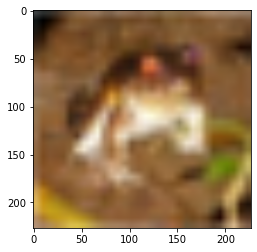

(227, 227, 3)
tf.Tensor(6, shape=(), dtype=int64)


In [12]:
ds_train = create_dataset("./data/cifar-10-batches-py/data_batch_1", batch_size = 4)
for batch_data, batch_label in ds_train.unbatch().take(1):
    plt.imshow(batch_data.numpy().astype("int32"))
    plt.show()
    print(batch_data.shape)
    print(tf.argmax(batch_label))

## 2.2 使用二进制读取的方式构造Dataset
使用TensorFlow提供的二进制处理API, 来解析数据集。

In [6]:
def parse_bin_data(file):
    input_bytes = tf.io.read_file(file)
    raw_data = tf.reshape(tf.io.decode_raw(input_bytes, "uint8"), [10000, 3073])
    label, data = tf.split(raw_data, [1, -1], 1)
    # 处理data
    data = tf.reshape(data, [10000, 3, 32, 32])
    data = tf.transpose(data, [0, 2, 3, 1])  # 调整通道顺序 channel last
    data = tf.cast(data, tf.float32) / 255.
#     data = tf.image.resize(data, [227, 227])  数据量太大
    # 处理label为one-hot
    label = tf.squeeze(tf.one_hot(label, 10))
    return tf.data.Dataset.from_tensor_slices((data, label))

In [7]:
def create_dataset_from_bin(dir_, batch_size = 8):
    ds = tf.data.Dataset.list_files(dir_)  \
            .interleave(parse_bin_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)  \
            .batch(batch_size)  \
            .prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2.2.1 训练集数据

In [8]:
ds_train_bin = create_dataset_from_bin("./data/cifar-10-batches-bin/data_*", 10)

(32, 32, 3)
(10,)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


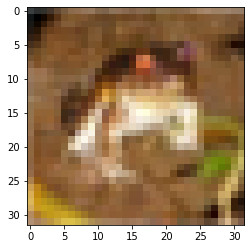

In [9]:
for img, label in ds_train_bin.unbatch().take(1):
    print(img.shape)
    print(label.shape)
    plt.imshow(img.numpy())
    print(label)
    plt.show()

### 2.2.2 测试集数据

In [10]:
# 加载测试集数据
ds_test_bin = create_dataset_from_bin("./data/cifar-10-batches-bin/test_*", 10)

(32, 32, 3)
(10,)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


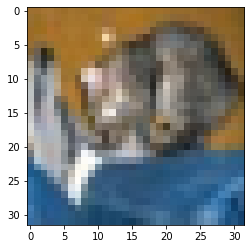

In [11]:
for img, label in ds_test_bin.unbatch().take(1):
    print(img.shape)
    print(label.shape)
    plt.imshow(img.numpy())
    print(label)
    plt.show()

### 2.2. 验证集
保证验证集于测试集同分布, 就从测试集中抽取20%作为验证集

In [12]:
ds_val_bin = ds_test_bin.shard(5, 1)

(32, 32, 3)
(10,)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


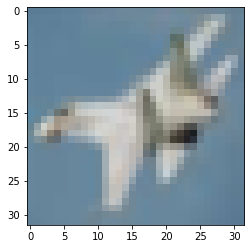

In [13]:
for img, label in ds_val_bin.unbatch().take(1):
    print(img.shape)
    print(label.shape)
    plt.imshow(img.numpy())
    print(label)
    plt.show()

## 3 训练模型

In [14]:
tf.keras.backend.clear_session()
alex = AlexNet()

In [15]:
logdir = 'keras_model_log/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=1, min_lr=0.00001)   # 1个epoch之后还没有精度上升的话就减小一半学习率
alex.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics="accuracy")

In [16]:
alex.build(input_shape=(None, 32, 32, 3))

In [17]:
alex.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  34944     
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  614656    
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0  

In [18]:
# 开始训练模型, 拿测试集的20%用来做validation
history = alex.fit(ds_train_bin, callbacks = [tensorboard_callback, reduce_lr], epochs = 10, validation_data = ds_val_bin)

Epoch 1/10
      2/Unknown - 0s 173ms/step - loss: 2.9406 - accuracy: 0.1500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.175686). Check your callbacks.
5000/5000 [==============================] - 89s 18ms/step - loss: 1.8641 - accuracy: 0.3647 - val_loss: 1.6343 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - 88s 18ms/step - loss: 1.5733 - accuracy: 0.4870 - val_loss: 1.4933 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - 89s 18ms/step - loss: 1.4668 - accuracy: 0.5346 - val_loss: 1.4205 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 4/10
5000/5000 [==============================] - 89s 18ms/step - loss: 1.3786 - accuracy: 0.5671 - val_loss: 1.4456 - val_accuracy: 0.5465 - lr: 0.0010
Epoch 5/10
5000/5000 [==============================] - 88s 18ms/step - loss: 1.1882 - accuracy: 0.6286 - val_loss: 1.2621 - val_accuracy: 0.6020 - lr: 5.0000e-04
Epoch 6/10
5000/50

## 4 保存模型
通过继承Keras.Model的模型是无法直接被save为h5文件的, 这里保存为tensorflow的SavedModel标准格式, 当然也可以只是保存权重后再自己构建网络(save_weights)。

pb是protocol（协议） buffer（缓冲）, TensorFlow训练模型后存成的pb文件。

In [19]:
model_dir = "./alexnet_cifar10_10epochs"

In [20]:
alex.save(model_dir, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./alexnet_cifar10_10epochs\assets


In [21]:
# 加载模型
model = tf.keras.models.load_model(model_dir)  # 这里不直接使用tf.saved_model.load, 因为这个方法是无法还原出keras对象的。

In [22]:
model.evaluate(ds_test_bin)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.3033 - accuracy: 0.6359


[1.3032766580581665, 0.6359000205993652]

## 5 继续数训练模型

In [23]:
model.fit(ds_train_bin, callbacks = [tensorboard_callback, reduce_lr], epochs = 6, validation_data = ds_val_bin)

Epoch 1/6
      2/Unknown - 0s 145ms/step - loss: 0.7049 - accuracy: 0.8000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.145433). Check your callbacks.
5000/5000 [==============================] - 89s 18ms/step - loss: 0.6162 - accuracy: 0.8298 - val_loss: 1.3480 - val_accuracy: 0.6380 - lr: 1.2500e-04
Epoch 2/6
5000/5000 [==============================] - 88s 18ms/step - loss: 0.5753 - accuracy: 0.8448 - val_loss: 1.3880 - val_accuracy: 0.6345 - lr: 1.2500e-04
Epoch 3/6
5000/5000 [==============================] - 88s 18ms/step - loss: 0.4621 - accuracy: 0.8880 - val_loss: 1.5093 - val_accuracy: 0.6430 - lr: 6.2500e-05
Epoch 4/6
5000/5000 [==============================] - 88s 18ms/step - loss: 0.4589 - accuracy: 0.8856 - val_loss: 1.5160 - val_accuracy: 0.6365 - lr: 6.2500e-05
Epoch 5/6
5000/5000 [==============================] - 88s 18ms/step - loss: 0.3665 - accuracy: 0.9248 - val_loss: 1.6326 - val_accuracy: 0.6430 - lr: 3.1250e-05
Epoch 6

In [24]:
model.evaluate(ds_test_bin)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.6812 - accuracy: 0.6317


[1.6811984777450562, 0.6316999793052673]

In [25]:
model.save("./alexnet_cifar10_16epochs", save_format='tf')

INFO:tensorflow:Assets written to: ./alexnet_cifar10_16·epochs\assets


**目前的精度为训练集91%, 测试集为63%**

## 6. 更换为SGD精调

In [26]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics="accuracy")

In [27]:
model.fit(ds_train_bin, callbacks = [tensorboard_callback, reduce_lr], epochs = 2, validation_data = ds_val_bin)

Epoch 1/2
      2/Unknown - 0s 125ms/step - loss: 0.4138 - accuracy: 0.9000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.124832). Check your callbacks.
5000/5000 [==============================] - 85s 17ms/step - loss: 0.3502 - accuracy: 0.9264 - val_loss: 1.6361 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 2/2
5000/5000 [==============================] - 85s 17ms/step - loss: 0.3444 - accuracy: 0.9286 - val_loss: 1.6351 - val_accuracy: 0.6420 - lr: 1.0000e-04


In [28]:
model.evaluate(ds_test_bin)  # 上升了一点点, 但是不明显

1000/1000 [==============================] - 5s 5ms/step - loss: 1.6757 - accuracy: 0.6321


[1.6757193803787231, 0.632099986076355]

# 7 数据增强
* 随机翻折数据  tf.image.flip_left_right(image)   
* 调整数据的饱和度  tf.image.adjust_saturation(image, 3)
* 旋转数据90°  tf.image.rot90(image)  这里就不用这个
* 改变明度  tf.image.adjust_brightness(image, 0.4)

Tensorflow除了提供这些操作的原始实现, 还给了random实现

In [34]:
def augment(image, label):
    # 数据增强的概率为10%
    if tf.random.uniform([1], 0, 1) < 0.1:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_saturation(image, 5, 10)
        image = tf.image.random_brightness(image, 0.2)
    return (image, label)

In [35]:
augmented_train_data = ds_train_bin.map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [36]:
model.fit(augmented_train_data, callbacks = [tensorboard_callback, reduce_lr], epochs = 5, validation_data = ds_val_bin)

Epoch 1/5
      2/Unknown - 0s 108ms/step - loss: 0.4683 - accuracy: 0.9000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.110796). Check your callbacks.
5000/5000 [==============================] - 83s 17ms/step - loss: 0.5308 - accuracy: 0.8838 - val_loss: 1.6042 - val_accuracy: 0.6370 - lr: 1.0000e-04
Epoch 2/5
5000/5000 [==============================] - 84s 17ms/step - loss: 0.5013 - accuracy: 0.8931 - val_loss: 1.5760 - val_accuracy: 0.6365 - lr: 1.0000e-04
Epoch 3/5
5000/5000 [==============================] - 84s 17ms/step - loss: 0.4998 - accuracy: 0.8929 - val_loss: 1.5737 - val_accuracy: 0.6365 - lr: 5.0000e-05
Epoch 4/5
5000/5000 [==============================] - 85s 17ms/step - loss: 0.4803 - accuracy: 0.9000 - val_loss: 1.5449 - val_accuracy: 0.6425 - lr: 2.5000e-05
Epoch 5/5
5000/5000 [==============================] - 84s 17ms/step - loss: 0.4988 - accuracy: 0.8905 - val_loss: 1.5528 - val_accuracy: 0.6360 - lr: 2.5000e-05


In [37]:
model.evaluate(ds_test_bin)  # 提升不明显

1000/1000 [==============================] - 5s 5ms/step - loss: 1.5730 - accuracy: 0.6323


[1.5730010271072388, 0.6323000192642212]

In [38]:
m = tf.keras.models.load_model("./alexnet_cifar10_16epochs")

In [39]:
m.evaluate(ds_test_bin)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.6812 - accuracy: 0.6317


[1.6811984777450562, 0.6316999793052673]

In [40]:
m.evaluate(ds_train_bin)

5000/5000 [==============================] - 26s 5ms/step - loss: 0.4131 - accuracy: 0.9016


[0.4130837023258209, 0.9016199707984924]

In [42]:
model.evaluate(ds_test_bin)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.5730 - accuracy: 0.6323


[1.5730010271072388, 0.6323000192642212]

In [41]:
model.evaluate(ds_train_bin)

5000/5000 [==============================] - 26s 5ms/step - loss: 0.4055 - accuracy: 0.9027


[0.4054562449455261, 0.9027199745178223]

## 8 保存最终版的模型

In [43]:
model.save("./alexnet_cifar10_final", save_format='tf')

INFO:tensorflow:Assets written to: ./alexnet_cifar10_final\assets


In [44]:
c = tf.keras.models.load_model("./alexnet_cifar10_final")

In [45]:
c.evaluate(ds_test_bin)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.5730 - accuracy: 0.6323


[1.5730010271072388, 0.6323000192642212]